# Simple Digits Classifier

In this notebook, we'll go over the steps necessary to implement a simple neural network classifier. We'll utilize popular machine-learning libraries, which take care of much of the work for us. Our programming language of choice here is Python, a standard in data science. We are using the test set of the UCI ML hand-written digits data sets, which consists of 1,797 images of 8x8 grayscale digits from 0 to 9.

To begin, we'll list off the libraries we are importing:

*   **PyTorch**: PyTorch is one of the most popular Python libraries for deep learning and neural networks. Initially developed by Facebook's AI Research lab (before Facebook's rebrand as Meta), PyTorch is straightforward to use. It lends itself well to prototyping, making it popular in academia and research. PyTorch provides tools to define, train, and evaluate neural network models. At its core, PyTorch utilizes *tensors*, multi-dimensional arrays that can be moved onto GPUs for accelerated computation.
*   **scikit-learn**: scikit-learn is a library that features several data science tools, such as algorithms for regression, classification, and clustering. For this notebook, we will use the library to obtain the UCI data set, split it into training and test sets, and calculate the confusion matrix of our trained model.
*   **Matplotlib**: The rest of these libraries are for visualization purposes. Matplotlib is a popular plotting library for Python, used to create various plots, graphs, and even animations. It is easy to use, highly customizable and is commonly integrated with other popular Python data science libraries.
*   **seaborn**: Seaborn is another library with visualization tools. It focuses primarily on statistical graphics. We'll use it to plot a confusion matrix when we evaluate our model.
*   **torchsummary**: We will use this library to display our network's architecture, including the number of trainable parameters.

In [1]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

# scikit-learn imports
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary

## Loading the UCI data set

As previously stated, we are using the UCI ML handwritten digits data set. The data set consists of 1,791 images of handwritten digits from 0 to 9. These images are 8x8 and grayscale. Each pixel value ranges from 0 to 16; the higher the value, the darker the pixel. This data set is included in the `scikit-learn` library. As such, a convenient `load_digits()` function in `scikit-learn` lets us get this data set.

For our neural network, we want to work with 8x8 binary images rather than 8x8 grayscale images. To do so, we'll set all pixels that exceed a threshold value to 1 and make the rest 0. This part of the machine learning process is called *data preprocessing*. We also split the dataset into a training set and a test set. The training set of images is used when we train the neural network, which consists of 80% of the 1,791 images. The remaining 20% of images are in the test set, which is only used to evaluate the neural network after training.

Finally, we use a utility class from PyTorch called a `DataLoader` to store the images. These are conveniently compatible when feeding data into the neural network, either while training or after training. They also automatically shuffle the data set and batch the images. Both shuffling the data set and batching the inputs are techniques that help the training of the neural network.

Note that the shuffle is only done once per iteration through the data set. We will go through all the images in the training set multiple times when training the neural network. One pass through the training set is called an *epoch*. By shuffling the data set each epoch, the order in which the neural network sees the images changes each epoch, which has been shown to help with the convergence of the network to a local minimum.

Batching the inputs has also been shown to help convergence, and a multiple of 2 is typically chosen for the batch size; we chose 32 arbitrarily here. Batching inputs means that the neural network will calculate the gradient using 32 images simultaneously. Alternatives would be to show it only one image at a time or the entire data set at a time. The former usually results in slower learning, and the latter does not scale well for large data sets.

Finally, as a sanity check, we visualize some images from the data set. We choose a random batch of 32 digits to display in the top-left corner of each cell, we display the label for that image. In our data set, the label is the digit that was drawn. The goal of the neural network is to predict this label.

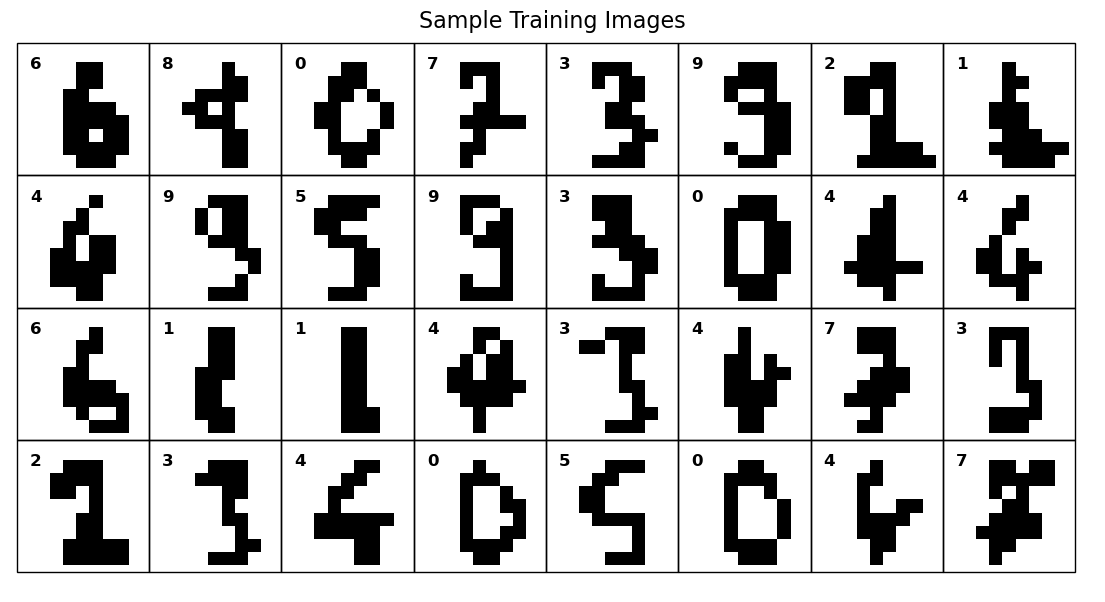

In [2]:
# Set the RNG seed to ensure reproducibility
torch.manual_seed(0)

# Load the (test set of the) UCI ML hand-written digits datasets
digits = load_digits()

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(digits.images >= 8, digits.target, test_size=0.2, random_state=0)

# Create PyTorch DataLoader for the training set
trainset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

# Create PyTorch DataLoader for the test set
testset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
testloader = DataLoader(testset, batch_size=32, shuffle=False)


# VISUALIZATION: show one training batch of images in a grid
dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(make_grid(images.unsqueeze(1))[0].numpy(), cmap="gray_r")
for idx, (image, label) in enumerate(zip(images, labels)):
    x, y = 10 * (idx % 8), 10 * (idx // 8)
    ax.add_patch(plt.Rectangle((x, y), 10, 10, edgecolor="black", fill=False))
    ax.text(x + 1, y + 2, str(label.item()), fontsize=12, weight="bold")
ax.axis("off")
ax.set_title("Sample Training Images", fontsize=16)
plt.show()

## Building the Network

Next, we'll build our neural network. Our target network architecture should look like this:
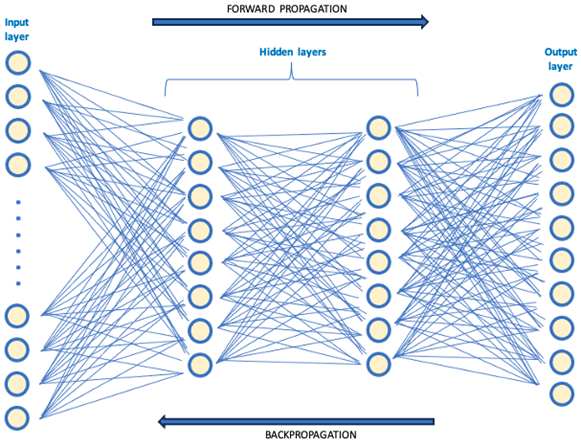

As you can see from the code below, writing this basic neural network is extremely simple, thanks to PyTorch. Any neural network model in PyTorch should inherit from the nn.Module class, ensuring it's fully compatible with PyTorch's extensive neural network functionalities. In the constructor, we define the three layers of our network. `nn.Linear` refers to the linear transformation (**w** *x* + **b**) of the inputs in the layers. The first parameter is the number of inputs and the second is the number of outputs.

Then, we need to define what a forward pass through the network looks like. This must all go in the `forward()` function, which has a parameter x. For us, x refers to an input batch of 8x8 images. The variable `x` will represent the data as it passes through the network. The first step, corresponding to the input layer, is to "flatten" the image, converting it to a 64-dimensional vector instead. This is achieved by using the `view()` function.

Next, we pass `x` into the first hidden layer, `fc1`, after which we apply the ReLU activation function. We repeat the process for the second hidden layer, `fc2`. Finally, we pass `x` to the output layer, which does not use an activation function. The return value of the `forward()` is thus the output of the model. The magical thing about PyTorch is that the backward pass of the model is automatically computed based on your `forward()` function! As such, many of the mathematical inner workings of neural networks are hidden from the user. Of course, if you want to pry it open, such as if you're implementing a custom activation function, you are able to with PyTorch.

We define the variable `net` to be our neural network model.

For visualization at this stage, we use a `summary()` function (from the `torchsummary` library) to display the layers, their associated output shapes, and the number of trainable parameters. These parameters get tuned as the model is trained on the training data set to minimize the cost function. The `-1` in the output shape refers to the batch size; our model accepts any value for the batch size as it doesn't affect the number of parameters. Larger batch sizes will result in bigger matrix multiplications (and thus a slower pass through the network), but the math doesn't change.

We see the two hidden layers, along with the output layer. The first hidden layer has a weight matrix of 8x64 and a bias vector of 8x1. Thus, the number of parameters for this layer is 8x64 + 8x1 = 512 + 8 = 520. The second hidden layer has a weight matrix of 8x8 and a bias vector of 8x1, giving us 8x8 + 8x1 = 64 + 8 = 72 parameters. Finally, the output layer has a 10x8 weight matrix and a 10x1 bias vector, giving us 10x8 + 10x1 = 80 + 10 = 90 parameters. This is 520 + 72 + 90 = 682 total parameters for our model. This is not even 1MB worth of parameters, so our model is incredibly small. Larger models, such as ChatGPT, have millions to even trillions of parameters.

In [3]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()

        # The first hidden layer, with 64 inputs and 8 outputs
        self.fc1 = nn.Linear(8 * 8, 8)

        # Use ReLU as the activation function of the first hidden layer
        self.relu1 = nn.ReLU()

        # The second hidden layer, with 8 inputs and 8 outputs
        self.fc2 = nn.Linear(8, 8)

        # Use ReLU as the activation function of the second hidden layer
        self.relu2 = nn.ReLU()

        # The output layer, with 8 inputs and 10 outputs
        self.fc3 = nn.Linear(8, 10)

    def forward(self, x):
        # The input layer, flattening the input tensor into a 64-dimensional vector
        x = x.view(-1, 8 * 8)

        # Run `x` through the first hidden layer, using the ReLU activation function
        x = self.relu1(self.fc1(x))

        # Run `x` through the second hidden layer, using the ReLU activation function
        x = self.relu2(self.fc2(x))

        # Run `x` through the output layer (note no activation function)
        x = self.fc3(x)

        return x


net = SimpleNN()


# VISUALIZATION: show the weights of the network
summary(net, (32, 8, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]             520
              ReLU-2                    [-1, 8]               0
            Linear-3                    [-1, 8]              72
              ReLU-4                    [-1, 8]               0
            Linear-5                   [-1, 10]              90
Total params: 682
Trainable params: 682
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


## Training the Network

Next, we will train our neural network. Training involves showing the network images from our training dataset. The network will then calculate a loss (or cost) value by comparing its output to the target output. Then, the value is used to adjust the network's parameters (weights and bias values) to improve its performance. As mentioned, the network calculates the loss value based on a batch of 32 images at a time. Once the network sees the entire training data set, that is one epoch. We will train our network for ten epochs. Values such as the batch size or the number of epochs to train are referred to as *hyperparameters*. For our example, we've chosen these values mostly arbitrarily. There are heuristics and methods to adjust these hyperparameters to improve the model's performance, but we will omit that process here. Typically, however, many hyperparameters, such as the exact architecture of the network, are not an exact science and come down to intuition.

To train our neural network, we need some way to evaluate its performance. This is achieved through a *loss function*, also known as a *cost function*. The loss function takes the model's output, compares it to the desired output, and returns some value. Typically, the smaller the value, the better the model's performance. For our example, we use *mean-squared loss*. The desired output for an image would be a 10-dimensional vector with 1 in the place that represents that digit and 0s elsewhere. This type of vector is also known as a *one-hot vector*. Mean-squared loss computes the squared difference between each element in the model's output vector and this desired target vector. Then, it averages these sums to produce the loss value. The larger the value, the larger the inaccuracies in the model's prediction.

Once we have this loss value, we can use it to adjust the weights (and biases) of the neural network such that this value would decrease should the network see that input again. This is achieved using calculus: we want to minimize the loss function, so take its derivative and find the parameters that minimize it. Normally, you would set it to 0 and solve for these parameters, but the loss function is a complex function composed of both the neural network and the input images. As such, solving for the parameters this way is not possible. Instead, we use a process called *backpropagation* to "push" this loss value backwards through the network. At each layer, the *gradient* (the higher-dimensional equivalent to the slope) is calculated by applying the chain rule as, functionally, the network can be considered as a composition of each layer. The gradient is then used to adjust the weight through *gradient descent*, moving the weights in the direction of the negative of the gradient. We move in the negative direction to minimize the loss value.

However, exactly how we adjust the weights can be modified. Such modified gradient descent algorithms are typically called *optimizers*. In our example, we will employ simple *stochastic gradient descent* (stochastic refers to the fact that this gradient is only a partial gradient since we are not using the full data set in its calculation). This algorithm only has one parameter: the *learning rate*. This is a measure of how much in the direction of the negative gradient we should move. If this value is too small, it will require many more epochs to converge. Too large, and we will overshoot the minimum and fail to converge. This is also a hyperparameter of the model, and finding the best value is an art. One could also decrease this value as training continues (called *learning rate decay*) and dynamically adjust it based on the gradient; however, we won't explore this here.

You'll notice in the code below that the definition of the loss function and the optimizer is a single line each. This is because PyTorch has already implemented the most popular algorithms for each. Next, we set up the training loop for the network. Again, we run the training for ten epochs, so we start with a `for`-loop over `range(100)`. We'll also keep track of the average loss values over the batches during each epoch. We print out these averages every epoch to see how the loss changes as we train the network. The next `for`-loop, on line 17, iterates through the `DataLoader` class we used to store the training data. When we iterate over this class, the `data` variable will contain the training data for one batch. The next step, on line 19, is to split the training data into the inputs and the outputs. Then, we need to zero the gradients using `optimizer.zero_grad()`. This is necessary as we want the gradient calculations only to consider the inputs for the current training batch. More complex algorithms may not zero the gradients here. Still, you need to do this step for most networks, as PyTorch does not automatically zero the gradients. The next line runs the input through the network; this is done in PyTorch by treating the `net` variable representing our neural network as a callable and passing in the input data. Once this forward pass is completed, we can compute the gradient of a backward pass using `loss.backward()`. The entire backpropagation step is contained in this one function call! Such is the power and utility of using a library like PyTorch. Note using the `one_hot()` function here to one-hot encode the target labels. Then, once the gradients are computed, we need to update the weights. This is achieved by doing `optimizer.step()`.

Once the training is completed, we plot the losses over epochs during training. Generally, loss values are hard to interpret. However, we do see that the loss value decreases at each epoch, which is good. This shows that the neural network is improving! However, we see that the improvements get smaller with each epoch. The loss value will likely plateau at some point, which is the point at which the model reaches a local minimum. However, as we know, a local minimum may not be a global minimum. It's possible that we can push the model's performance further with a different random initialization of the model's weights, with a different loss function, or through other techniques.

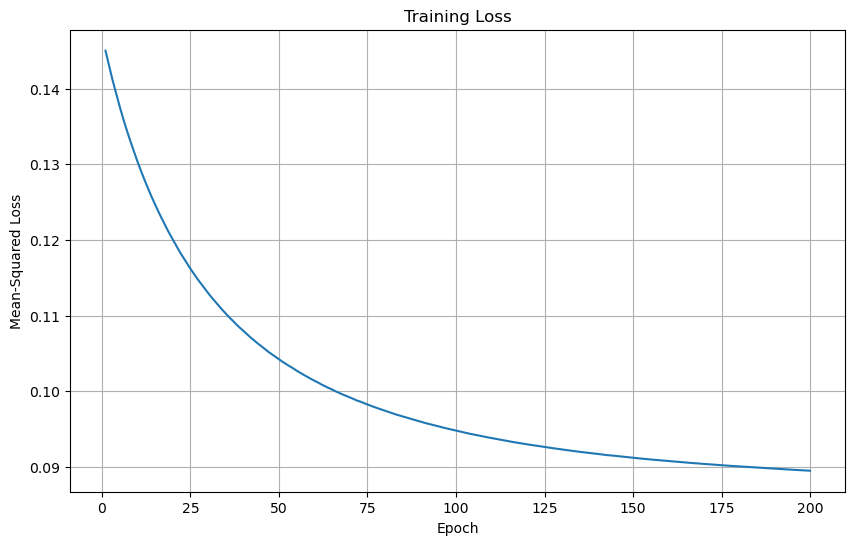

In [4]:
# Define our loss (cost) function to be mean-squared error
criterion = nn.MSELoss()

# Use standard stochastic gradient descent
optimizer = optim.SGD(net.parameters(), lr=0.001)

# Keep a record of the average loss value after each epoch
losses = []

# Train the model for 200 epochs
for epoch in range(200):
    # An accumulator to keep track of the loss values in this epoch
    running_loss = 0.0

    # Using the DataLoader, we can loop through batches of training data
    # `i` is the batch number, and `data` is the batch of training images
    for i, data in enumerate(trainloader):
        # Get the training inputs and target labels for the batch
        inputs, labels = data

        # Zero the parameter gradients, because each training batch should be indepently calculated
        # This step may be omitted in more complex neural network algorithms
        optimizer.zero_grad()

        # Push the input images through the network and obtain the predicted labels
        outputs = net(inputs.float())

        # Calculate the loss value based on the predicted labels and the target labels
        loss = criterion(outputs, F.one_hot(labels.long(), num_classes=10).float())

        # Propogate the loss backwards; i.e. perform backpropogation
        # This function call calculates the gradients for the entire network!
        loss.backward()

        # Updates the weights using SGD; i.e. perform gradient descent
        # This function call updates all the trainable parameters of the model, based on the gradient calculated in the previous step
        optimizer.step()

        # Keep track of the loss value for this batch
        running_loss += loss.item()

    # Once the epoch terminated, record the average loss for the epoch
    losses.append(running_loss / len(trainloader))


# VISUALIZATION: display a line plot of the training loss over epochs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, 201), losses)
ax.set_title("Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean-Squared Loss")
ax.grid(True)
plt.show()

Finally, we visualize the weight matrices in the neural network. We'll skip over the first hidden layer, as this is a fairly large matrix to visualize. We show below the matrices learned by the neural network in the second hidden layer and the output layer. It isn't easy to gain insights from these images; they look like a random matrix of numbers within a fairly small range centred around 0. However, that's probably a good thing. Overly large weights would likely be a sign that something is wrong. Similarly, too many zero weights or too many weights with the same value would likely indicate something is amiss. However, this is only sometimes the case, so diagnosing the network like this is difficult. This difficulty in interpreting how the neural network works leads to the issue of *interpretability*. Neural networks are typically described as "black-box" algorithms because it's difficult to understand how they work. This leads to issues of trust, bias, and transparency, all challenges that are very much present in current-day AI technologies such as ChatGPT and autonomous vehicles.

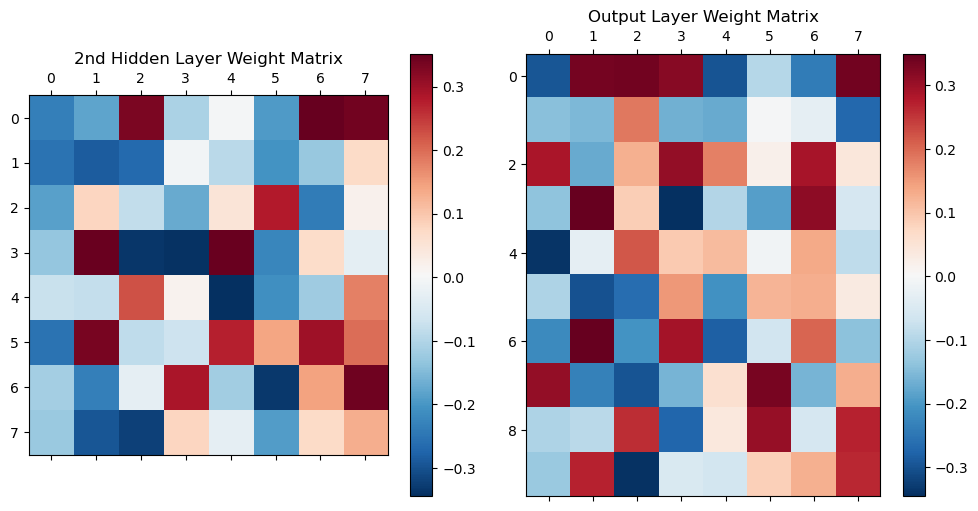

In [5]:
# VISUALIZATION: visualize the weights of the last two layers
weights_fc2 = net.fc2.weight.data.numpy()
weights_fc3 = net.fc3.weight.data.numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
cax2 = axs[0].matshow(weights_fc2, cmap="RdBu_r")
fig.colorbar(cax2, ax=axs[0])
axs[0].set_title("2nd Hidden Layer Weight Matrix")
cax3 = axs[1].matshow(weights_fc3, cmap="RdBu_r")
fig.colorbar(cax3, ax=axs[1])
axs[1].set_title("Output Layer Weight Matrix")
plt.tight_layout()
plt.show()

## Evaluating the Network

Now, we look to evaluate how well our model performs. For this, we use the test set. Recall that earlier, we set aside 20% images in the data set. It is only at this point that we should use this split. Since the model has yet to see images from this data set, and they were independently sampled from the original distribution of the images, this should give us an *unbiased* evaluation of the model's performance. However, it is also common in the real world that one would go back to the model and make changes to improve its performance on both the training set and test set. This would violate the unbiased properties of a test set; instead, this would make this data set a *validation data set*. For instance, in the original paper that used this data set, the test set may have been a true test set. However, as others have begun to use and evaluate their models on the same splits, the unbiasedness of the test set is lost. Still, we want to use data not seen during training to evaluate the model. If we used the training set for evaluation, the evaluation would be heavily biased. For example, the model may have learned to memorize the label for each training image and achieved perfect accuracy. However, if we applied this model to new data, it would likely fail spectacularly. This is a clear example of *overfitting*, whereas the overall goal of machine learning and AI is *generalization*.

Below, we have a loop similar to the training loop but instead loops over the test set. Note the use of `torch.no_grad()` to tell PyTorch that it doesn't need to worry about computing gradients, which helps with memory consumption. Once the model's predictions are obtained, we convert it back into a label by finding the index of the maximum value in the output vector. This is easily achieved by using the `argmax()` function in PyTorch. Finally, we keep track of both the number of correct predictions and the total number of images. The quotient of these two values is the model's accuracy, which we display. Our model gets a 14% accuracy.

This isn't good, to say the least. Part of the art of working with machine learning and AI is how to proceed from here. There is usually not a clear answer. For example, there may be a bug in the code, even in the library's code, which is the cause of these poor results. There may be bad data or not enough data. Perhaps the training/test split was not well done, and the training set was not a good sample of the true distribution of the data. Perhaps binarizing the image or scaling it down to 8x8 were bad ideas. Or perhaps we just needed to train for a longer period. We may need to change the loss function or the optimizer and its parameters. Alternatively, we may need to add more layers to our neural network or have more neurons in each layer. Or perhaps we just fell into a bad local minimum due to sheer luck. It's also possible that we need to explore novel approaches to improve accuracy.

In [6]:
# To calculate accuracy, we divide the number of correct prediction by the total number of images
correct = 0
total = 0

# We don't need to touch the gradient during evaluation
with torch.no_grad():
    # Loop through each batch in the test set
    for data in testloader:
        # Get the test inputs and target labels for the batch
        images, labels = data

        # Push the input images through the network and obtain the predicted labels
        outputs = net(images.float())

        # The output is a one-hot vector, so we want to get the index of the highest value
        predicted = torch.argmax(outputs.data, 1)

        # Increment accumulator keeping track of the number of images and correct prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Display the neural network's accuracy on the test set
print(f"Accuracy of the network on the 360 test images: {int(correct / total * 100)} %")

Accuracy of the network on the 360 test images: 14 %


Below, we show the activations for each layer for one input in the test set. We have the digit's image and its true label on the left. In the middle, we have the activations of each neuron in each layer. On the right, we have the predicted label. Note that the neuron with the highest activation value in the output layer corresponds to the predicted label. Rerun the code sell to see another random example.

As with visualizing the weights, it's not apparent what we're looking at with the activation values and how to diagnose the network. One might consider each activation value some feature the network has learned about the image. However, what exactly this feature is is not obvious, as it's a complex combination of every pixel in the image. Notice the effect of the ReLU activation function, where several nodes in each layer are set to an activation value of 0. This is a desirable property in several ways. For one, this makes the derivative computation much easier, as we're dealing with a sparser network. A sparser network can also increase the network's ability to generalize. Additionally, this has an effect where the network can dynamically control how many effective hidden neurons are in each layer.

We can also see that the magnitude of the activation representing the model's prediction in the output layer is not very close to 1, as one would desire. The target output would have a 1 in that place and 0 elsewhere. Again, it's not obvious what the next steps are; we might train for longer in the hopes it improves in accuracy, or we might try changing some things about the network and how it's trained.

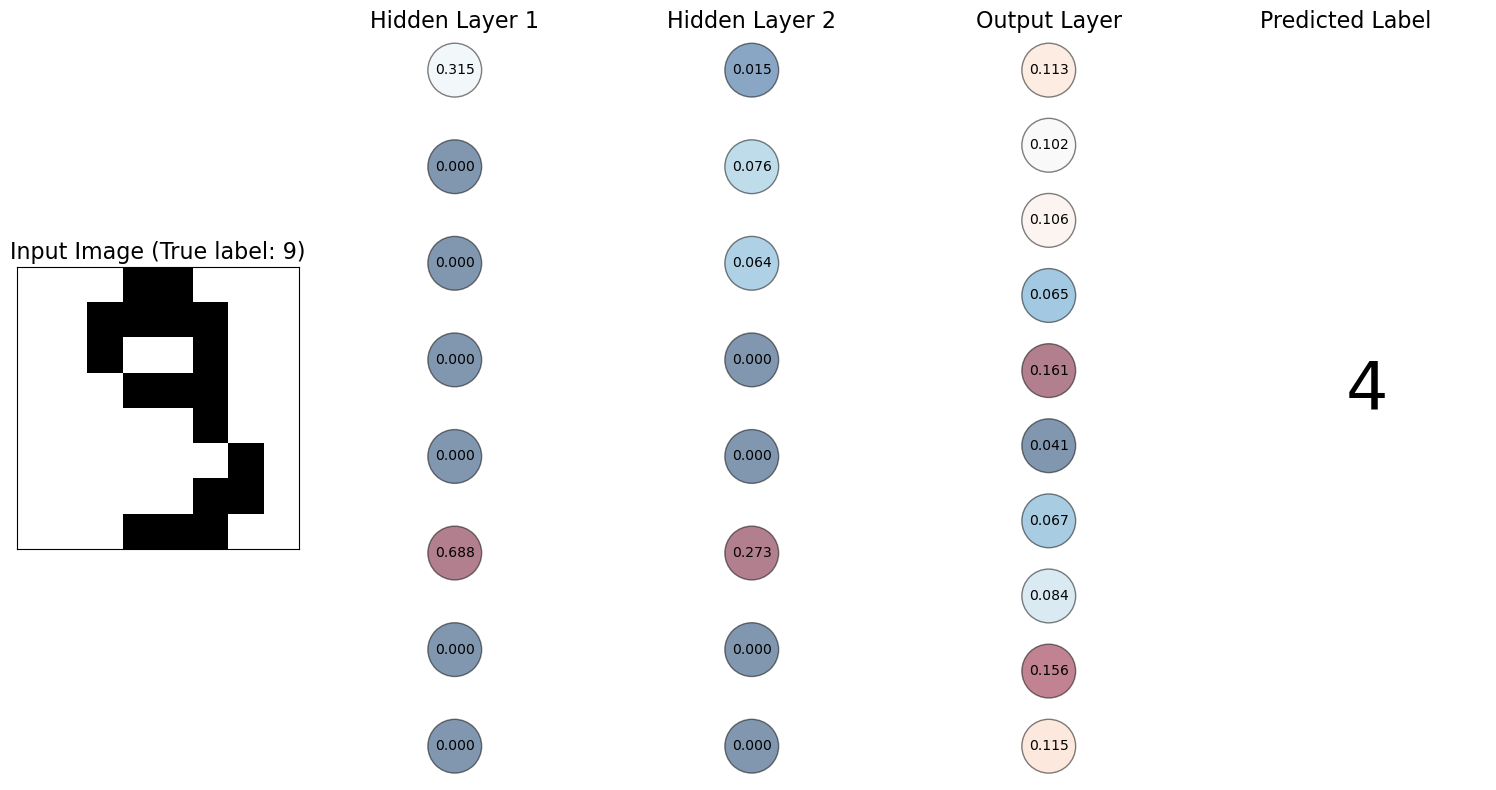

In [7]:
# VISUALIZATION: visualize the activations at each layer, along with the input image and predicted label
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()

    return hook

net.relu1.register_forward_hook(get_activation("layer1"))
net.relu2.register_forward_hook(get_activation("layer2"))
net.fc3.register_forward_hook(get_activation("output"))

input_image, label = next(iter(trainloader))
input_image = input_image[0]
label = label[0]

predicted_output = net(input_image.float())
predicted_label = torch.argmax(predicted_output).item()

fig, axes = plt.subplots(1, 5, figsize=(15, 8))
axes[0].imshow(input_image.squeeze().numpy(), cmap="gray_r")
axes[0].set_title(f"Input Image (True label: {label.item()})", fontsize=16)
axes[0].set_xticks([])
axes[0].set_yticks([])

activation_images = [activations["layer1"].numpy().T, activations["layer2"].numpy().T, activations["output"].numpy().T,]
layer_names = ["Hidden Layer 1", "Hidden Layer 2", "Output Layer"]
for i, activation in enumerate(activation_images):
    x, y = [0] * len(activation), list(range(len(activation) - 1, -1, -1))
    scatter = axes[i + 1].scatter(x, y, s=1500, c=activation, cmap="RdBu_r", edgecolors="k", alpha=0.5)
    for yi, val in zip(y, activation):
        label = f"{val.item():.3f}"
        axes[i + 1].text(0, yi, label, fontsize=10, ha="center", va="center")
    axes[i + 1].set_title(layer_names[i], fontsize=16)
    axes[i + 1].axis("off")

axes[4].text(0.5, 0.5, str(predicted_label), color="black", fontsize=48)
axes[4].set_title("Predicted Label", fontsize=16)
axes[4].axis("off")
plt.tight_layout()
plt.show()

Finally, we plot a confusion matrix to understand how the model classifies each digit and what kinds of mistakes it makes. The x-axis represents the model's predicted label, and the y-axis represents the actual label. Thus, values along the main diagonal of the confusion matrix represent correctly classified digits. Ideally, we'd like to see a strongly-diagonal matrix, but our model does not produce such one. For our run of the model, it appears to predict 4 well, but never predicts 0, 1, 3, 5, or 6. Clearly, our model has not learned about the data correctly. Likely, it has defaulted to guessing 4 almost all the time without learning about the differences between each digit. What should we do from here?

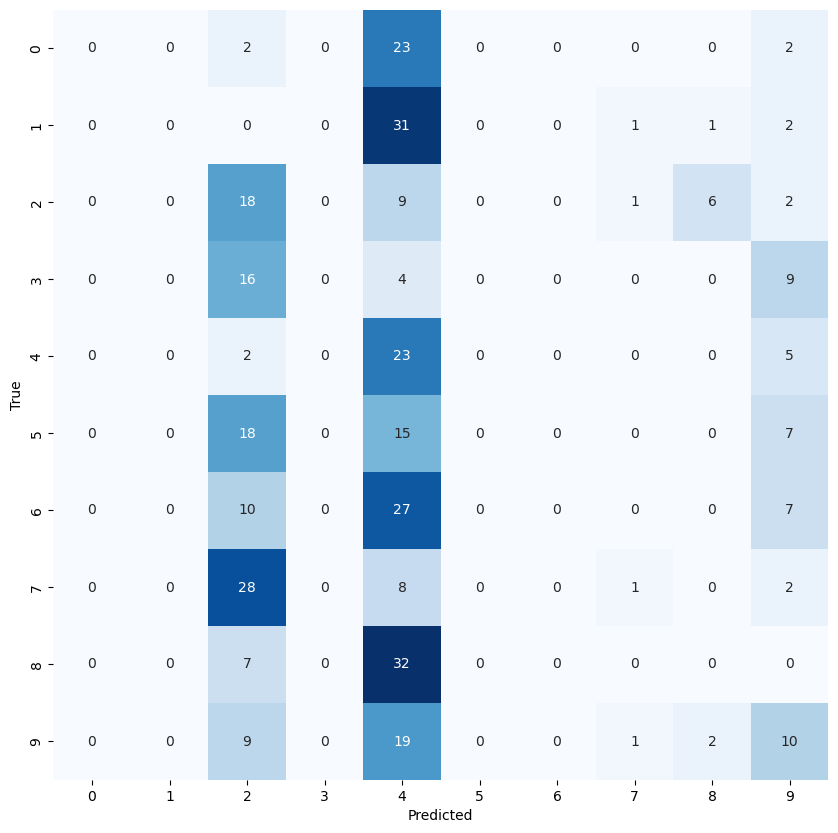

In [8]:
# VISUALIZATION: visualize a confusion matrix for the network
true_labels = []
pred_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.float())
        predicted = torch.argmax(outputs.data, 1)
        true_labels.extend(labels.tolist())
        pred_labels.extend(predicted.tolist())

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()